#Deep Learning Modelo

##Pipeline de trabajo y modelos

Antes de presentar el modelo definitivo, que es el que ha obtenido el mejor valor de accuracy sobre el conjunto de test, se van a describir los distintos modelos que se han ido probando, así como el proceso de trabajo seguido hasta llegar a la solución final.

En primer lugar, tras una fase inicial de investigación sobre distintos backbones que podían resultar adecuados para este problema, se decidió centrar el estudio en las arquitecturas EfficientNet y ResNet. En ambos casos se comenzó probando una configuración general, con el objetivo de tener una primera referencia y poder comparar qué arquitectura ofrecía un mejor comportamiento en este conjunto de datos.

Para el caso de ResNet, se obtuvieron los siguientes resultados:

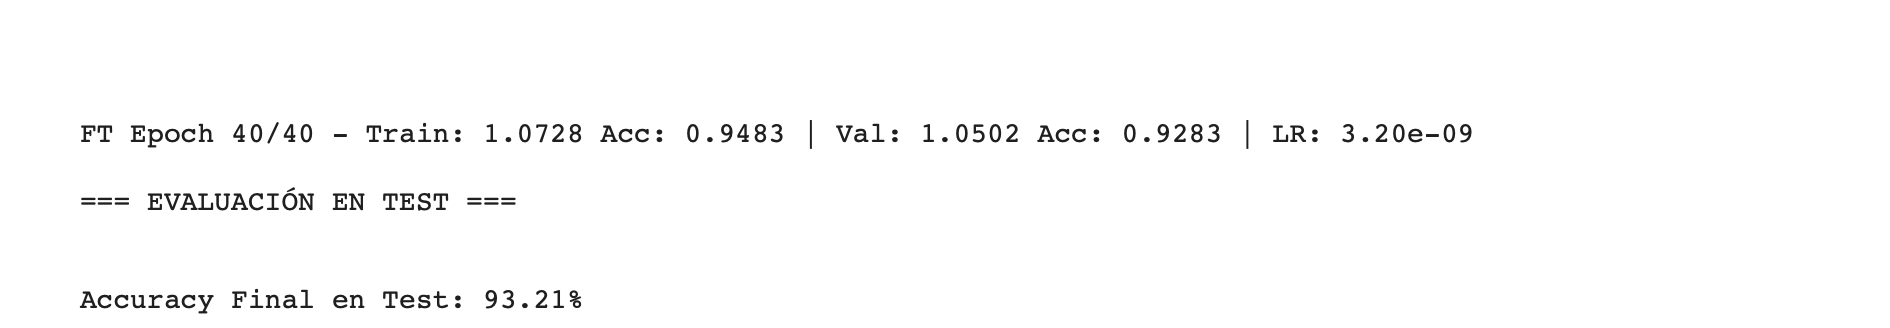

El código completo correspondiente a esta arquitectura se encuentra en el archivo ResNet.ipynb, por si fuera de interés analizarlo con mayor detalle. No obstante, conviene señalar que esta primera prueba ha sido generada íntegramente mediante herramientas de inteligencia artificial y no ha sido posteriormente modificada ni ajustada de forma manual, ya que se trata de un modelo que no se ha desarrollado ni afinado específicamente para este trabajo.

Por otro lado, en el caso de EfficientNet se obtuvieron resultados ligeramente superiores en términos de accuracy. Además, se observó que el proceso de entrenamiento era considerablemente más rápido, lo que, unido a los mejores resultados iniciales, motivó la decisión de centrar los esfuerzos en intentar mejorar el rendimiento utilizando este backbone.

Partiendo de la arquitectura base de EfficientNet, se probaron distintas combinaciones con el objetivo de analizar cómo afectaba el tamaño del modelo y la complejidad del clasificador final al rendimiento obtenido.

En primer lugar, se evaluó una variante EfficientNet Large a la que se añadieron varias capas de clasificación en la parte final. Este modelo fue el más pesado de todos los considerados y, en consecuencia, el que mayor tiempo de entrenamiento requirió. Como contrapartida, fue también el que alcanzó los mejores resultados en términos de accuracy.
El código correspondiente a esta configuración se encuentra adjunto en el archivo Ef_L_con_capas.ipynb.

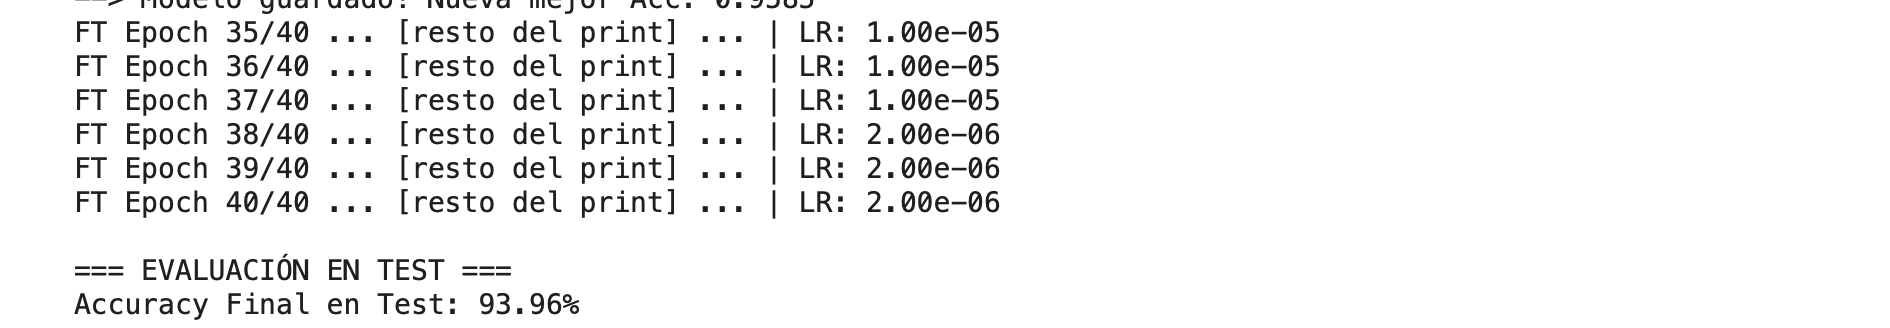

EfficientNet Large sin capas de clasificación añadidas. En este caso, se optó por eliminar las capas de clasificación añadidas en la parte final del modelo y utilizar directamente la capa clasificadora propia que incorpora la arquitectura EfficientNet. Para ello, dicha capa se dejó entrenable desde el inicio, mientras que el resto del backbone permaneció congelado.
Este planteamiento permitió reducir de forma notable el tiempo de entrenamiento; sin embargo, el rendimiento obtenido fue ligeramente inferior en comparación con el modelo anterior. Esta configuración se corresponde con el modelo denominado Ef_L_sin_capas.

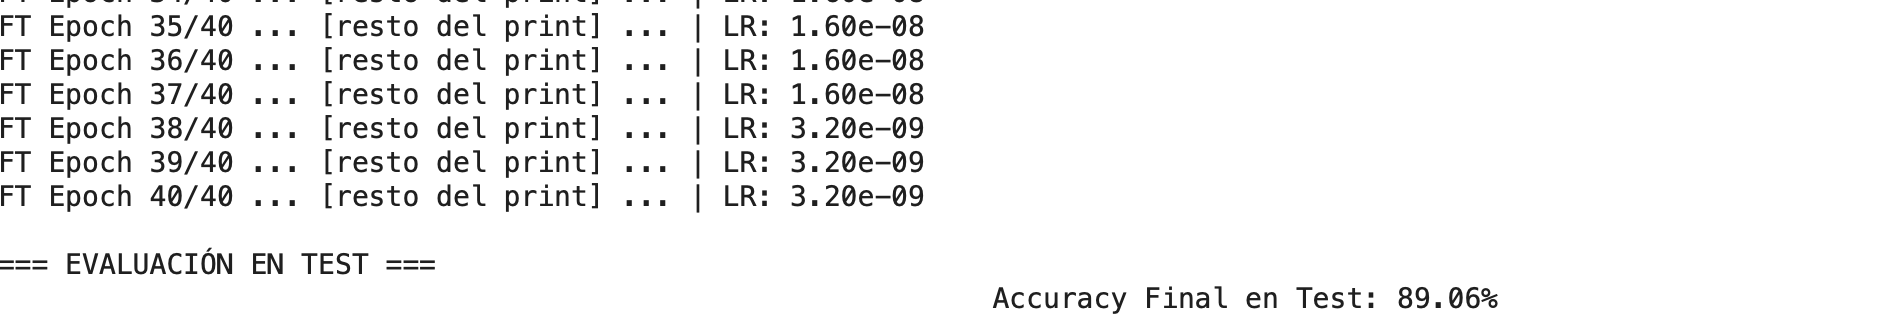

EfficientNet Small sin capas de clasificación añadidas. En este último modelo se dio un giro a la filosofía seguida en las configuraciones anteriores, optando por una arquitectura lo más sencilla posible. En este sentido, se partió de la idea de que, en determinados casos, un modelo menos complejo puede ofrecer un buen rendimiento sin necesidad de introducir un exceso de capas o parámetros.

Este enfoque resultó funcionar considerablemente bien. Además, el reducido tiempo de entrenamiento facilitó el ajuste de hiperparámetros relacionados con problemas de underfitting y overfitting, ya que cualquier modificación realizada tenía un impacto visible de forma casi inmediata durante el proceso de entrenamiento. Desde un punto de vista práctico, este fue el modelo que mejor se logró comprender y controlar, a pesar de no ser el que alcanzó los mejores resultados finales en términos de accuracy. Esta configuración corresponde al modelo denominado Ef_S_sin_capas.

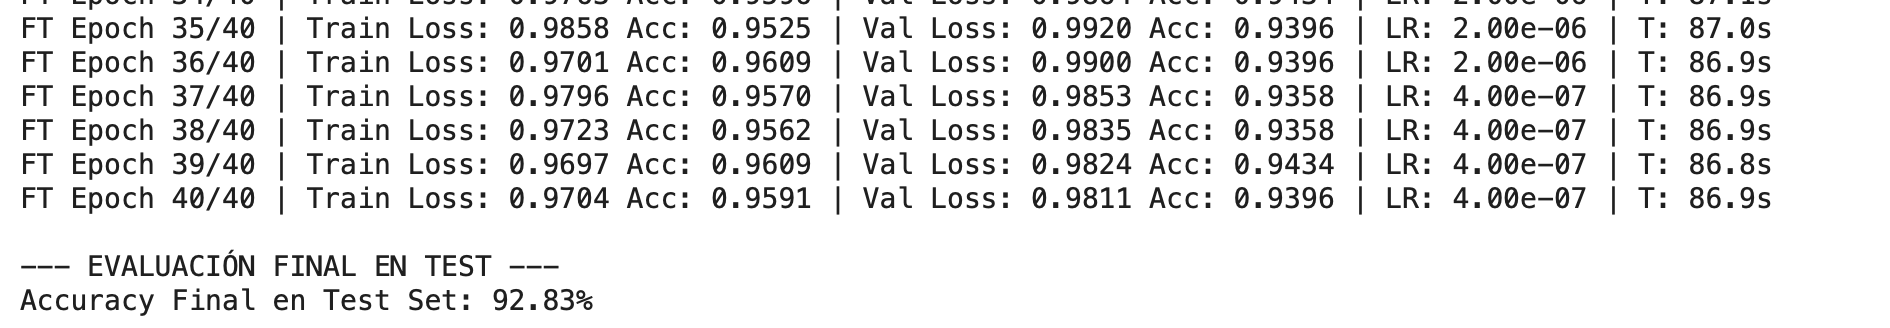

En los tres modelos de EfficientNet descritos anteriormente, durante cada entrenamiento se realizó un seguimiento intermedio de la evolución de los valores de accuracy y loss tanto en el conjunto de entrenamiento como en el de validación. Este análisis permitió detectar de forma temprana posibles problemas de overfitting o underfitting. En aquellos casos en los que se observaba un comportamiento no deseado, el entrenamiento se detenía y se probaban nuevas configuraciones de hiperparámetros, como el learning rate o el número de epochs, entre otros.

Asimismo, en los tres modelos se siguió una misma metodología de entrenamiento basada en dos fases. En una primera fase, el backbone se mantuvo congelado y únicamente se entrenaron las capas de clasificación. Posteriormente, se descongeló de forma parcial el backbone para realizar un proceso de fine-tuning, con el objetivo de adaptar de manera más específica las características aprendidas al problema de clasificación planteado.

Tras evaluar los tres modelos anteriores, se decidió realizar una última prueba aprovechando los pocos créditos de entrenamiento disponibles. El modelo seleccionado, y finalmente el que se ha adoptado como solución final, es el que se presenta en este notebook, basado en la arquitectura ConvNeXt. Se trata de una arquitectura que no se conocía previamente, pero que fue recomendada tanto por herramientas de inteligencia artificial como ChatGPT y Claude. Teniendo en cuenta que la familia EfficientNet ya se había explorado en profundidad y que no se estaba logrando mejorar su rendimiento, se consideró razonable dedicar los recursos restantes a probar una arquitectura distinta.

Con esta arquitectura se obtuvieron finalmente los mejores resultados en términos de accuracy. No obstante, el elevado tiempo de entrenamiento limitó la posibilidad de realizar un ajuste más exhaustivo de los hiperparámetros, ya que no se disponía de créditos suficientes para llevar a cabo un proceso de tuning más detallado. En este sentido, hubiera sido interesante poder afinar con mayor profundidad algunos de los parámetros del modelo, lo que probablemente habría permitido obtener un rendimiento aún mayor.

## Modelo Final

###Entrenamiento

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -q '/content/drive/MyDrive/Deep Learning/Labs/02 - CNN-Cards/Datasets/Cards.zip' -d '/content/sample_data/Datasets'

replace /content/sample_data/Datasets/test/ace of clubs/1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
# Importacion de librerias
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms as T
from torchvision.models import convnext_base, ConvNeXt_Base_Weights
from PIL import Image
import os
from tqdm import tqdm
import numpy as np
import random
import json
from datetime import datetime

# Rutas para las imagenes y guardado de los modelos
DATA_PATH = '/content/sample_data/Datasets/'
PATH_MODELS = '/content/drive/MyDrive/Deep Learning/Labs/02 - CNN-Cards/Models'

class Config:
    # Paths de train, test y valid
    train_dir = DATA_PATH+'train'
    val_dir = DATA_PATH+'valid'
    test_dir = DATA_PATH+'test'

    # Hiperparámetros optimizados
    img_size = 224
    batch_size = 4
    num_epochs = 50
    lr = 5e-5
    weight_decay = 0.05
    num_classes = 53

    # Mixup/CutMix es util en ConvNext, mas aun si es uno agresivo
    use_mixup = True
    mixup_alpha = 0.8
    cutmix_alpha = 1.0
    mixup_prob = 0.5

    # Test-Time Augmentation que mejora los resultados de accuracy en el test
    use_tta = True
    tta_transforms = 10

    # Gradient Accumulation
    accumulation_steps = 12

    # Device, se usa en pytorch
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Early stopping si no se mejora
    patience = 12

    # Ensemble, aqui hay posibilidad de haber hecho un ensemble para coger la prediccion media de varios modelos a la vez, se podría haber probado también pero no ha sido el caso
    train_ensemble = False
    num_models = 3

    # Label Smoothing (ConvNeXt funciona mejor con más smoothing)
    label_smoothing = 0.1

    # Stochastic Depth (regularización específica de ConvNeXt, no existe en muchos otros modelos)
    drop_path_rate = 0.2


# MixUp y CutMix

def mixup_data(x, y, alpha=1.0):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)

    mixed_x = lam * x + (1 - lam) * x[index]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def cutmix_data(x, y, alpha=1.0):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)

    bbx1, bby1, bbx2, bby2 = rand_bbox(x.size(), lam)
    x[:, :, bbx1:bbx2, bby1:bby2] = x[index, :, bbx1:bbx2, bby1:bby2]

    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (x.size()[-1] * x.size()[-2]))
    y_a, y_b = y, y[index]
    return x, y_a, y_b, lam

def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# Data Augmentation, es un data augmentation bastante agresivo y por eso tambien se ha tardado tanto en entrenar el modelo
def get_transforms():
    # ConvNeXt se beneficia de augmentations más fuertes
    train_transform = T.Compose([
        T.Resize((Config.img_size, Config.img_size)),
        T.RandomRotation(degrees=25),
        T.RandomAffine(degrees=0, translate=(0.2, 0.2), scale=(0.8, 1.2), shear=15),
        T.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.4, hue=0.15),
        T.RandomPerspective(distortion_scale=0.4, p=0.5),
        T.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0)),
        T.RandomAdjustSharpness(sharpness_factor=2, p=0.3),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        T.RandomErasing(p=0.25, scale=(0.02, 0.2), ratio=(0.3, 3.3))
    ])

    eval_transform = T.Compose([
        T.Resize((Config.img_size, Config.img_size)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    return train_transform, eval_transform


# Dataset

class PokerDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}

        self.samples = []
        for class_name in self.classes:
            class_dir = os.path.join(root_dir, class_name)
            if os.path.isdir(class_dir):
                for img_name in os.listdir(class_dir):
                    if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                        self.samples.append((
                            os.path.join(class_dir, img_name),
                            self.class_to_idx[class_name]
                        ))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

# Modelo
class PokerConvNeXt(nn.Module):
    def __init__(self, num_classes, drop_path_rate=0.2):
        super(PokerConvNeXt, self).__init__()

        # Cargar ConvNeXt-Base con pesos pre-entrenados, cong
        weights = ConvNeXt_Base_Weights.IMAGENET1K_V1
        self.backbone = convnext_base(weights=weights)

        # ConvNeXt tiene una estructura diferente a EfficientNet
        # El clasificador está en backbone.classifier
        in_features = self.backbone.classifier[2].in_features

        # Reemplazar el clasificador, creamos ahora una red que funcione como clasificador en la parte final de la red
        # ConvNeXt usa LayerNorm en lugar de BatchNorm
        self.backbone.classifier = nn.Sequential(
            nn.Flatten(1), # Flatten before LayerNorm
            nn.LayerNorm(in_features, eps=1e-6),
            nn.Dropout(p=0.5),
            nn.Linear(in_features, 1024),
            nn.GELU(),  # ConvNeXt usa GELU en lugar de ReLU
            nn.Dropout(p=0.3),
            nn.Linear(1024, 512),
            nn.GELU(),
            nn.Dropout(p=0.2),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.backbone(x)

# TTA para el test, esto mejora el accuracy ya que el modelo evalua el test de varias maneras de tal manera que su prediccion final es la media de todas estas predicciones. De este modo, es menos probable que se equivoque

def apply_tta(model, inputs, num_augments=10):
    model.eval()
    predictions = []

    with torch.no_grad():
        # Predicción original
        predictions.append(F.softmax(model(inputs), dim=1))

        # Augmentations
        for i in range(num_augments - 1):
            aug_inputs = inputs.clone()

            # Flip horizontal
            if i % 3 == 0:
                aug_inputs = torch.flip(aug_inputs, dims=[3])

            # Flip vertical
            if i % 3 == 1:
                aug_inputs = torch.flip(aug_inputs, dims=[2])

            # Rotación pequeña
            if i >= 6:
                angle = random.choice([-5, 5])
                aug_inputs = T.functional.rotate(aug_inputs, angle)

            predictions.append(F.softmax(model(aug_inputs), dim=1))

    return torch.stack(predictions).mean(dim=0)

# Training

class ConvNeXtTrainer:
    def __init__(self, model, train_loader, val_loader, criterion, optimizer, scheduler, model_name='convnext'):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.model_name = model_name
        self.best_acc = 0.0
        self.patience_counter = 0

    def train_epoch(self, epoch):
        self.model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        pbar = tqdm(self.train_loader, desc=f'[{self.model_name}] Epoch {epoch+1}')
        self.optimizer.zero_grad()

        for batch_idx, (inputs, labels) in enumerate(pbar):
            inputs, labels = inputs.to(Config.device), labels.to(Config.device)

            # Mixup/CutMix que se ha definido arriba
            if Config.use_mixup and random.random() < Config.mixup_prob:
                if random.random() < 0.5:
                    inputs, labels_a, labels_b, lam = mixup_data(inputs, labels, Config.mixup_alpha)
                else:
                    inputs, labels_a, labels_b, lam = cutmix_data(inputs, labels, Config.cutmix_alpha)

                outputs = self.model(inputs)
                loss = mixup_criterion(self.criterion, outputs, labels_a, labels_b, lam)
            else:
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)

            loss = loss / Config.accumulation_steps
            loss.backward()

            if (batch_idx + 1) % Config.accumulation_steps == 0:
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                self.optimizer.step()
                self.optimizer.zero_grad()

            running_loss += loss.item() * Config.accumulation_steps
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            pbar.set_postfix({
                'loss': f'{running_loss/(batch_idx+1):.4f}',
                'acc': f'{100.*correct/total:.2f}%',
                'lr': f'{self.optimizer.param_groups[0]["lr"]:.6f}'
            })

        return running_loss/len(self.train_loader), 100.*correct/total

# Validacion

    def validate(self, use_tta=False):
        self.model.eval()
        running_loss = 0.0
        correct = 0
        total = 0

        desc = f'[{self.model_name}] Val{"idation" if not use_tta else " + TTA"}'
        with torch.no_grad():
            for inputs, labels in tqdm(self.val_loader, desc=desc):
                inputs, labels = inputs.to(Config.device), labels.to(Config.device)

                if use_tta and Config.use_tta:
                    outputs = apply_tta(self.model, inputs, Config.tta_transforms)
                else:
                    outputs = self.model(inputs)
                    loss = self.criterion(outputs, labels)
                    running_loss += loss.item()

                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_loss = running_loss/len(self.val_loader) if not use_tta else 0.0
        val_acc = 100.*correct/total

        return val_loss, val_acc

    def train(self, num_epochs):
        print(f'\n🚀 [{self.model_name}] Iniciando entrenamiento ConvNeXt')
        print(f'   • Batch size efectivo: {Config.batch_size * Config.accumulation_steps}')
        print(f'   • Mixup alpha: {Config.mixup_alpha}')

        for epoch in range(num_epochs):
            print(f'\n{"="*70}')
            print(f'[{self.model_name}] Epoch {epoch+1}/{num_epochs}')
            print("="*70)

            train_loss, train_acc = self.train_epoch(epoch)
            val_loss, val_acc = self.validate(use_tta=False)

            print(f'\n📊 Resultados:')
            print(f'   Train → Loss: {train_loss:.4f} | Acc: {train_acc:.2f}%')
            print(f'   Val   → Loss: {val_loss:.4f} | Acc: {val_acc:.2f}%')

            # Scheduler step (ConvNeXt usa CosineAnnealing mejor)
            self.scheduler.step()

            if val_acc > self.best_acc:
                self.best_acc = val_acc

                # Validación con TTA que hemos definido arriba
                if Config.use_tta and epoch > 10:  # Solo TTA después de epoch 10
                    print('   🔄 Evaluando con TTA...')
                    _, val_acc_tta = self.validate(use_tta=True)
                    print(f'   Val + TTA → Acc: {val_acc_tta:.2f}%')

                torch.save({
                    'epoch': epoch,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'val_acc': val_acc,
                }, f'best_{self.model_name}.pth')
                print(f'   ✅ Mejor modelo guardado! Acc: {val_acc:.2f}%')
                self.patience_counter = 0
            else:
                self.patience_counter += 1
                print(f'   ⏳ Sin mejora ({self.patience_counter}/{Config.patience})')

            if self.patience_counter >= Config.patience:
                print('\n⚠️  Early stopping!')
                break

        return self.best_acc


# Evaluacion en Test

def evaluate_test(model, test_loader, use_tta=True, model_name='ConvNeXt'):
    print(f'\n{"="*70}')
    print(f'🎯 EVALUACIÓN FINAL EN TEST - {model_name}')
    print("="*70)

    model.eval()
    correct = 0
    total = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc=f'Test (TTA={use_tta})'):
            inputs, labels = inputs.to(Config.device), labels.to(Config.device)

            if use_tta and Config.use_tta:
                outputs = apply_tta(model, inputs, Config.tta_transforms)
            else:
                outputs = F.softmax(model(inputs), dim=1)

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_acc = 100. * correct / total

    print(f'\n{"="*70}')
    print(f'📊 RESULTADO FINAL - {model_name}')
    print(f'   ⭐ Test Accuracy: {test_acc:.4f}%')
    print(f'   ✓ Correctas: {correct}/{total}')
    print(f'   ✗ Incorrectas: {total-correct}/{total}')
    print("="*70)

    return test_acc, all_predictions, all_labels

# Ensemble en el caso de que quisieramos hacerlo, esta es la funcion en la que se evalua

def evaluate_ensemble(models, test_loader):
    print(f'\n{"="*70}')
    print(f'🎯 EVALUACIÓN ENSEMBLE ({len(models)} modelos ConvNeXt)')
    print("="*70)

    for model in models:
        model.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc='Ensemble + TTA'):
            inputs, labels = inputs.to(Config.device), labels.to(Config.device)

            ensemble_outputs = []
            for model in models:
                if Config.use_tta:
                    outputs = apply_tta(model, inputs, Config.tta_transforms)
                else:
                    outputs = F.softmax(model(inputs), dim=1)
                ensemble_outputs.append(outputs)

            final_outputs = torch.stack(ensemble_outputs).mean(dim=0)
            _, predicted = final_outputs.max(1)

            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    test_acc = 100. * correct / total

    print(f'\n{"="*70}')
    print(f'📊 RESULTADO FINAL - ENSEMBLE')
    print(f'   ⭐ Test Accuracy: {test_acc:.4f}%')
    print(f'   ✓ Correctas: {correct}/{total}')
    print("="*70)

    return test_acc


# Ejecucion del programa

def main():
    # Limpiar memoria
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        import gc
        gc.collect()

    # Seeds
    torch.manual_seed(42)
    np.random.seed(42)
    random.seed(42)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(42)
        torch.backends.cudnn.benchmark = True  # Acelera ConvNeXt

    print('='*70)
    print('🎴 CLASIFICADOR DE CARTAS DE POKER - ConvNeXt')
    print('='*70)
    print(f'🖥️  Device: {Config.device}')
    if torch.cuda.is_available():
        print(f'   GPU: {torch.cuda.get_device_name(0)}')
        print(f'   VRAM: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB')

    # Transforms
    train_transform, eval_transform = get_transforms()

    # Datasets
    print(f'\n📂 Cargando datasets...')
    train_dataset = PokerDataset(Config.train_dir, transform=train_transform)
    val_dataset = PokerDataset(Config.val_dir, transform=eval_transform)
    test_dataset = PokerDataset(Config.test_dir, transform=eval_transform)

    # DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=Config.batch_size,
                             shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=Config.batch_size,
                           shuffle=False, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=Config.batch_size,
                            shuffle=False, num_workers=2, pin_memory=True)

    print(f'\n📊 Dataset Info:')
    print(f'   Clases: {len(train_dataset.classes)}')
    print(f'   Train: {len(train_dataset):,} imágenes')
    print(f'   Val: {len(val_dataset):,} imágenes')
    print(f'   Test: {len(test_dataset):,} imágenes ⭐')

    Config.num_classes = len(train_dataset.classes)

    if not Config.train_ensemble:
        print('\n🎯 Modo: UN MODELO ConvNeXt')

        model = PokerConvNeXt(
            num_classes=Config.num_classes,
            drop_path_rate=Config.drop_path_rate
        ).to(Config.device)

        # Contar parámetros
        total_params = sum(p.numel() for p in model.parameters())
        print(f'\n🧠 Modelo ConvNeXt-Base:')
        print(f'   Parámetros: {total_params:,}')

        criterion = nn.CrossEntropyLoss(label_smoothing=Config.label_smoothing)

        # ConvNeXt usa AdamW con LayerDecay
        optimizer = optim.AdamW(
            model.parameters(),
            lr=Config.lr,
            weight_decay=Config.weight_decay,
            betas=(0.9, 0.999)
        )

        # Scheduler: Cosine Annealing (mejor para ConvNeXt)
        scheduler = optim.lr_scheduler.CosineAnnealingLR(
            optimizer,
            T_max=Config.num_epochs,
            eta_min=1e-7
        )

        trainer = ConvNeXtTrainer(model, train_loader, val_loader,
                                  criterion, optimizer, scheduler, 'convnext')
        best_val_acc = trainer.train(Config.num_epochs)

        # Cargar mejor modelo
        checkpoint = torch.load('best_convnext.pth')
        model.load_state_dict(checkpoint['model_state_dict'])

        # EVALUACIÓN EN TEST
        test_acc, _, _ = evaluate_test(model, test_loader, use_tta=True,
                                       model_name='ConvNeXt-Base')

        result = {
            'model_type': 'convnext_base',
            'test_accuracy': test_acc,
            'val_accuracy': best_val_acc,
            'config': {
                'img_size': Config.img_size,
                'batch_size': Config.batch_size,
                'mixup_alpha': Config.mixup_alpha,
                'tta_transforms': Config.tta_transforms
            },
            'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        }

        with open('convnext_test_results.json', 'w') as f:
            json.dump(result, f, indent=4)

        print(f'\n💾 Resultados guardados en: convnext_test_results.json')

    else:
        print(f'\n🎯 Modo: ENSEMBLE de {Config.num_models} ConvNeXt')
        models = []

        for i in range(Config.num_models):
            print(f'\n{"#"*70}')
            print(f'Modelo {i+1}/{Config.num_models}')
            print("#"*70)

            torch.manual_seed(42 + i)
            np.random.seed(42 + i)
            random.seed(42 + i)

            model = PokerConvNeXt(Config.num_classes, Config.drop_path_rate).to(Config.device)
            criterion = nn.CrossEntropyLoss(label_smoothing=Config.label_smoothing)
            optimizer = optim.AdamW(model.parameters(), lr=Config.lr,
                                   weight_decay=Config.weight_decay)
            scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer,
                                                            T_max=Config.num_epochs)

            trainer = ConvNeXtTrainer(model, train_loader, val_loader,
                                     criterion, optimizer, scheduler, f'convnext_{i+1}')
            trainer.train(Config.num_epochs)

            checkpoint = torch.load(f'best_convnext_{i+1}.pth')
            model.load_state_dict(checkpoint['model_state_dict'])
            models.append(model)

            evaluate_test(model, test_loader, use_tta=True,
                         model_name=f'ConvNeXt {i+1}')

        # ENSEMBLE
        ensemble_acc = evaluate_ensemble(models, test_loader)

        result = {
            'model_type': 'convnext_ensemble',
            'num_models': Config.num_models,
            'ensemble_test_accuracy': ensemble_acc,
            'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        }

        with open('convnext_test_results.json', 'w') as f:
            json.dump(result, f, indent=4)

    print('\n✅ PROCESO COMPLETADO!')
    print('='*70)

if __name__ == '__main__':
  main()

🎴 CLASIFICADOR DE CARTAS DE POKER - ConvNeXt
🖥️  Device: cuda
   GPU: Tesla T4
   VRAM: 15.8 GB

📂 Cargando datasets...

📊 Dataset Info:
   Clases: 53
   Train: 7,624 imágenes
   Val: 265 imágenes
   Test: 265 imágenes ⭐

🎯 Modo: UN MODELO ConvNeXt

🧠 Modelo ConvNeXt-Base:
   Parámetros: 89,168,053

🚀 [convnext] Iniciando entrenamiento ConvNeXt
   • Batch size efectivo: 48
   • Mixup alpha: 0.8

[convnext] Epoch 1/50


[convnext] Validation: 100%|██████████| 67/67 [00:05<00:00, 11.75it/s]



📊 Resultados:
   Train → Loss: 3.7540 | Acc: 7.04%
   Val   → Loss: 3.0581 | Acc: 20.75%
   ✅ Mejor modelo guardado! Acc: 20.75%

[convnext] Epoch 2/50


[convnext] Validation: 100%|██████████| 67/67 [00:03<00:00, 19.74it/s]



📊 Resultados:
   Train → Loss: 3.0189 | Acc: 19.67%
   Val   → Loss: 2.3080 | Acc: 38.11%
   ✅ Mejor modelo guardado! Acc: 38.11%

[convnext] Epoch 3/50


[convnext] Validation: 100%|██████████| 67/67 [00:03<00:00, 19.64it/s]



📊 Resultados:
   Train → Loss: 2.6865 | Acc: 27.98%
   Val   → Loss: 2.0380 | Acc: 46.79%
   ✅ Mejor modelo guardado! Acc: 46.79%

[convnext] Epoch 4/50


[convnext] Validation: 100%|██████████| 67/67 [00:03<00:00, 19.56it/s]



📊 Resultados:
   Train → Loss: 2.5062 | Acc: 34.10%
   Val   → Loss: 1.7961 | Acc: 56.98%
   ✅ Mejor modelo guardado! Acc: 56.98%

[convnext] Epoch 5/50


[convnext] Validation: 100%|██████████| 67/67 [00:03<00:00, 18.94it/s]



📊 Resultados:
   Train → Loss: 2.3569 | Acc: 40.82%
   Val   → Loss: 1.6061 | Acc: 69.81%
   ✅ Mejor modelo guardado! Acc: 69.81%

[convnext] Epoch 6/50


[convnext] Validation: 100%|██████████| 67/67 [00:03<00:00, 19.67it/s]



📊 Resultados:
   Train → Loss: 2.1959 | Acc: 48.01%
   Val   → Loss: 1.3931 | Acc: 78.87%
   ✅ Mejor modelo guardado! Acc: 78.87%

[convnext] Epoch 7/50


[convnext] Validation: 100%|██████████| 67/67 [00:03<00:00, 19.37it/s]



📊 Resultados:
   Train → Loss: 2.0874 | Acc: 53.84%
   Val   → Loss: 1.2905 | Acc: 82.26%
   ✅ Mejor modelo guardado! Acc: 82.26%

[convnext] Epoch 8/50


[convnext] Validation: 100%|██████████| 67/67 [00:03<00:00, 19.33it/s]



📊 Resultados:
   Train → Loss: 1.9815 | Acc: 58.17%
   Val   → Loss: 1.1407 | Acc: 88.30%
   ✅ Mejor modelo guardado! Acc: 88.30%

[convnext] Epoch 9/50


[convnext] Validation: 100%|██████████| 67/67 [00:03<00:00, 19.51it/s]



📊 Resultados:
   Train → Loss: 1.8740 | Acc: 61.90%
   Val   → Loss: 1.0785 | Acc: 89.81%
   ✅ Mejor modelo guardado! Acc: 89.81%

[convnext] Epoch 10/50


[convnext] Validation: 100%|██████████| 67/67 [00:03<00:00, 19.23it/s]



📊 Resultados:
   Train → Loss: 1.8298 | Acc: 64.61%
   Val   → Loss: 0.9976 | Acc: 93.21%
   ✅ Mejor modelo guardado! Acc: 93.21%

[convnext] Epoch 11/50


[convnext] Validation: 100%|██████████| 67/67 [00:03<00:00, 19.61it/s]



📊 Resultados:
   Train → Loss: 1.7614 | Acc: 66.26%
   Val   → Loss: 0.9476 | Acc: 95.09%
   ✅ Mejor modelo guardado! Acc: 95.09%

[convnext] Epoch 12/50


[convnext] Validation: 100%|██████████| 67/67 [00:03<00:00, 18.37it/s]



📊 Resultados:
   Train → Loss: 1.6947 | Acc: 68.64%
   Val   → Loss: 0.9343 | Acc: 95.09%
   ⏳ Sin mejora (1/12)

[convnext] Epoch 13/50


[convnext] Validation: 100%|██████████| 67/67 [00:03<00:00, 19.59it/s]



📊 Resultados:
   Train → Loss: 1.6614 | Acc: 69.20%
   Val   → Loss: 0.9210 | Acc: 95.09%
   ⏳ Sin mejora (2/12)

[convnext] Epoch 14/50


[convnext] Validation: 100%|██████████| 67/67 [00:03<00:00, 19.20it/s]



📊 Resultados:
   Train → Loss: 1.6552 | Acc: 68.72%
   Val   → Loss: 0.9050 | Acc: 95.85%
   🔄 Evaluando con TTA...


[convnext] Val + TTA: 100%|██████████| 67/67 [00:32<00:00,  2.06it/s]


   Val + TTA → Acc: 95.09%
   ✅ Mejor modelo guardado! Acc: 95.85%

[convnext] Epoch 15/50


[convnext] Validation: 100%|██████████| 67/67 [00:03<00:00, 19.23it/s]



📊 Resultados:
   Train → Loss: 1.5998 | Acc: 70.82%
   Val   → Loss: 0.8927 | Acc: 95.85%
   ⏳ Sin mejora (1/12)

[convnext] Epoch 16/50


[convnext] Validation: 100%|██████████| 67/67 [00:03<00:00, 19.08it/s]



📊 Resultados:
   Train → Loss: 1.5684 | Acc: 72.69%
   Val   → Loss: 0.8653 | Acc: 97.36%
   🔄 Evaluando con TTA...


[convnext] Val + TTA: 100%|██████████| 67/67 [00:32<00:00,  2.07it/s]


   Val + TTA → Acc: 95.47%
   ✅ Mejor modelo guardado! Acc: 97.36%

[convnext] Epoch 17/50


[convnext] Validation: 100%|██████████| 67/67 [00:03<00:00, 19.49it/s]



📊 Resultados:
   Train → Loss: 1.5625 | Acc: 72.38%
   Val   → Loss: 0.8522 | Acc: 97.36%
   ⏳ Sin mejora (1/12)

[convnext] Epoch 18/50


[convnext] Validation: 100%|██████████| 67/67 [00:03<00:00, 19.31it/s]



📊 Resultados:
   Train → Loss: 1.5442 | Acc: 72.59%
   Val   → Loss: 0.8501 | Acc: 98.11%
   🔄 Evaluando con TTA...


[convnext] Val + TTA: 100%|██████████| 67/67 [00:32<00:00,  2.07it/s]


   Val + TTA → Acc: 96.23%
   ✅ Mejor modelo guardado! Acc: 98.11%

[convnext] Epoch 19/50


[convnext] Validation: 100%|██████████| 67/67 [00:03<00:00, 18.90it/s]



📊 Resultados:
   Train → Loss: 1.4897 | Acc: 75.05%
   Val   → Loss: 0.8333 | Acc: 98.11%
   ⏳ Sin mejora (1/12)

[convnext] Epoch 20/50


[convnext] Validation: 100%|██████████| 67/67 [00:03<00:00, 19.32it/s]



📊 Resultados:
   Train → Loss: 1.5108 | Acc: 74.46%
   Val   → Loss: 0.8258 | Acc: 97.74%
   ⏳ Sin mejora (2/12)

[convnext] Epoch 21/50


[convnext] Validation: 100%|██████████| 67/67 [00:03<00:00, 19.59it/s]



📊 Resultados:
   Train → Loss: 1.4886 | Acc: 75.31%
   Val   → Loss: 0.8114 | Acc: 98.87%
   🔄 Evaluando con TTA...


[convnext] Val + TTA: 100%|██████████| 67/67 [00:32<00:00,  2.07it/s]


   Val + TTA → Acc: 98.87%
   ✅ Mejor modelo guardado! Acc: 98.87%

[convnext] Epoch 22/50


[convnext] Validation: 100%|██████████| 67/67 [00:03<00:00, 19.28it/s]



📊 Resultados:
   Train → Loss: 1.4603 | Acc: 76.21%
   Val   → Loss: 0.8053 | Acc: 99.62%
   🔄 Evaluando con TTA...


[convnext] Val + TTA: 100%|██████████| 67/67 [00:32<00:00,  2.07it/s]


   Val + TTA → Acc: 96.98%
   ✅ Mejor modelo guardado! Acc: 99.62%

[convnext] Epoch 23/50


[convnext] Validation: 100%|██████████| 67/67 [00:03<00:00, 18.98it/s]



📊 Resultados:
   Train → Loss: 1.4360 | Acc: 76.36%
   Val   → Loss: 0.8082 | Acc: 99.25%
   ⏳ Sin mejora (1/12)

[convnext] Epoch 24/50


[convnext] Validation: 100%|██████████| 67/67 [00:03<00:00, 18.88it/s]



📊 Resultados:
   Train → Loss: 1.4522 | Acc: 75.59%
   Val   → Loss: 0.7992 | Acc: 98.87%
   ⏳ Sin mejora (2/12)

[convnext] Epoch 25/50


[convnext] Validation: 100%|██████████| 67/67 [00:03<00:00, 19.56it/s]



📊 Resultados:
   Train → Loss: 1.4289 | Acc: 76.51%
   Val   → Loss: 0.8019 | Acc: 98.87%
   ⏳ Sin mejora (3/12)

[convnext] Epoch 26/50


[convnext] Validation: 100%|██████████| 67/67 [00:03<00:00, 19.61it/s]



📊 Resultados:
   Train → Loss: 1.4166 | Acc: 76.18%
   Val   → Loss: 0.7922 | Acc: 99.62%
   ⏳ Sin mejora (4/12)

[convnext] Epoch 27/50


[convnext] Validation: 100%|██████████| 67/67 [00:03<00:00, 19.49it/s]



📊 Resultados:
   Train → Loss: 1.4123 | Acc: 77.75%
   Val   → Loss: 0.7915 | Acc: 99.62%
   ⏳ Sin mejora (5/12)

[convnext] Epoch 28/50


[convnext] Validation: 100%|██████████| 67/67 [00:03<00:00, 18.83it/s]



📊 Resultados:
   Train → Loss: 1.3678 | Acc: 78.02%
   Val   → Loss: 0.7850 | Acc: 99.25%
   ⏳ Sin mejora (6/12)

[convnext] Epoch 29/50


[convnext] Validation: 100%|██████████| 67/67 [00:03<00:00, 19.10it/s]



📊 Resultados:
   Train → Loss: 1.3874 | Acc: 77.12%
   Val   → Loss: 0.7899 | Acc: 98.49%
   ⏳ Sin mejora (7/12)

[convnext] Epoch 30/50


[convnext] Validation: 100%|██████████| 67/67 [00:03<00:00, 19.34it/s]



📊 Resultados:
   Train → Loss: 1.3738 | Acc: 77.57%
   Val   → Loss: 0.7832 | Acc: 99.62%
   ⏳ Sin mejora (8/12)

[convnext] Epoch 31/50


[convnext] Validation: 100%|██████████| 67/67 [00:03<00:00, 19.62it/s]



📊 Resultados:
   Train → Loss: 1.3799 | Acc: 78.27%
   Val   → Loss: 0.7853 | Acc: 99.25%
   ⏳ Sin mejora (9/12)

[convnext] Epoch 32/50


[convnext] Validation: 100%|██████████| 67/67 [00:03<00:00, 19.33it/s]



📊 Resultados:
   Train → Loss: 1.3706 | Acc: 77.89%
   Val   → Loss: 0.7882 | Acc: 98.87%
   ⏳ Sin mejora (10/12)

[convnext] Epoch 33/50


[convnext] Validation: 100%|██████████| 67/67 [00:03<00:00, 18.96it/s]



📊 Resultados:
   Train → Loss: 1.3415 | Acc: 78.90%
   Val   → Loss: 0.7814 | Acc: 99.25%
   ⏳ Sin mejora (11/12)

[convnext] Epoch 34/50


[convnext] Validation: 100%|██████████| 67/67 [00:03<00:00, 19.60it/s]



📊 Resultados:
   Train → Loss: 1.3494 | Acc: 78.99%
   Val   → Loss: 0.7805 | Acc: 99.25%
   ⏳ Sin mejora (12/12)

⚠️  Early stopping!

🎯 EVALUACIÓN FINAL EN TEST - ConvNeXt-Base


Test (TTA=True): 100%|██████████| 67/67 [00:32<00:00,  2.07it/s]


📊 RESULTADO FINAL - ConvNeXt-Base
   ⭐ Test Accuracy: 96.6038%
   ✓ Correctas: 256/265
   ✗ Incorrectas: 9/265

💾 Resultados guardados en: convnext_test_results.json

✅ PROCESO COMPLETADO!


Una de los detalles que más me ha llamado la atención es los buenos resultados que ha obtenido con los datos de validación en función a los obtenidos con los datos de train. La capacidad de generalización que tiene el modelo es realmente buena.

### Evaluación en el test

Durante la fase de entrenamiento y evaluación del modelo probé inicialmente el uso de Test Time Augmentation (TTA). Esta técnica consiste en aplicar distintas transformaciones a las imágenes del conjunto de test, como pequeñas rotaciones o variaciones de escala, y combinar posteriormente las predicciones obtenidas, normalmente mediante un promedio. La idea detrás de este enfoque es aumentar la robustez del modelo durante la inferencia y reducir su sensibilidad a pequeñas variaciones en las imágenes de entrada.

Era una recomendación que muchas de las IA's hacían. Sin embargo, viendo que mi modelo sufría de muchas cosas pero no de overfitting, decidí probar a evaluar sin ello ya que sentía que es una técnica muy útil cuando el problema que tienes es el overfitting. Por lo tanto, el mejor de los resultados en el test se encuentra en la celda inferior.

La celda superior con la evluación con TTA no he podido cambiarla y eliminarla ya que no estaba seguro de que fuera a tener suficientes créditos para acabar el entrenamiento de nuevo.

In [ ]:
evaluate_test(model, test_loader, use_tta=False,
                                model_name='ConvNeXt-Base')


🎯 EVALUACIÓN FINAL EN TEST - ConvNeXt-Base


Test (TTA=False): 100%|██████████| 67/67 [00:03<00:00, 19.27it/s]


📊 RESULTADO FINAL - ConvNeXt-Base
   ⭐ Test Accuracy: 97.7358%
   ✓ Correctas: 259/265
   ✗ Incorrectas: 6/265


(97.73584905660377,
 [np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(1),
  np.int64(1),
  np.int64(1),
  np.int64(1),
  np.int64(1),
  np.int64(2),
  np.int64(2),
  np.int64(2),
  np.int64(2),
  np.int64(2),
  np.int64(3),
  np.int64(3),
  np.int64(3),
  np.int64(3),
  np.int64(3),
  np.int64(4),
  np.int64(4),
  np.int64(4),
  np.int64(4),
  np.int64(4),
  np.int64(5),
  np.int64(5),
  np.int64(5),
  np.int64(5),
  np.int64(5),
  np.int64(6),
  np.int64(6),
  np.int64(6),
  np.int64(6),
  np.int64(6),
  np.int64(7),
  np.int64(7),
  np.int64(7),
  np.int64(7),
  np.int64(7),
  np.int64(8),
  np.int64(8),
  np.int64(8),
  np.int64(8),
  np.int64(8),
  np.int64(9),
  np.int64(9),
  np.int64(9),
  np.int64(9),
  np.int64(9),
  np.int64(10),
  np.int64(10),
  np.int64(10),
  np.int64(10),
  np.int64(10),
  np.int64(11),
  np.int64(11),
  np.int64(11),
  np.int64(11),
  np.int64(11),
  np.int64(12),
  np.int64(12),
  np.int64(37),
  np.int64(12),
  np.i

En la celda superior, además de estar el accuracy en los datos de test, también se encuentran los valores reales y predichos de las 53 clases (0-52).

###Matriz de confusion

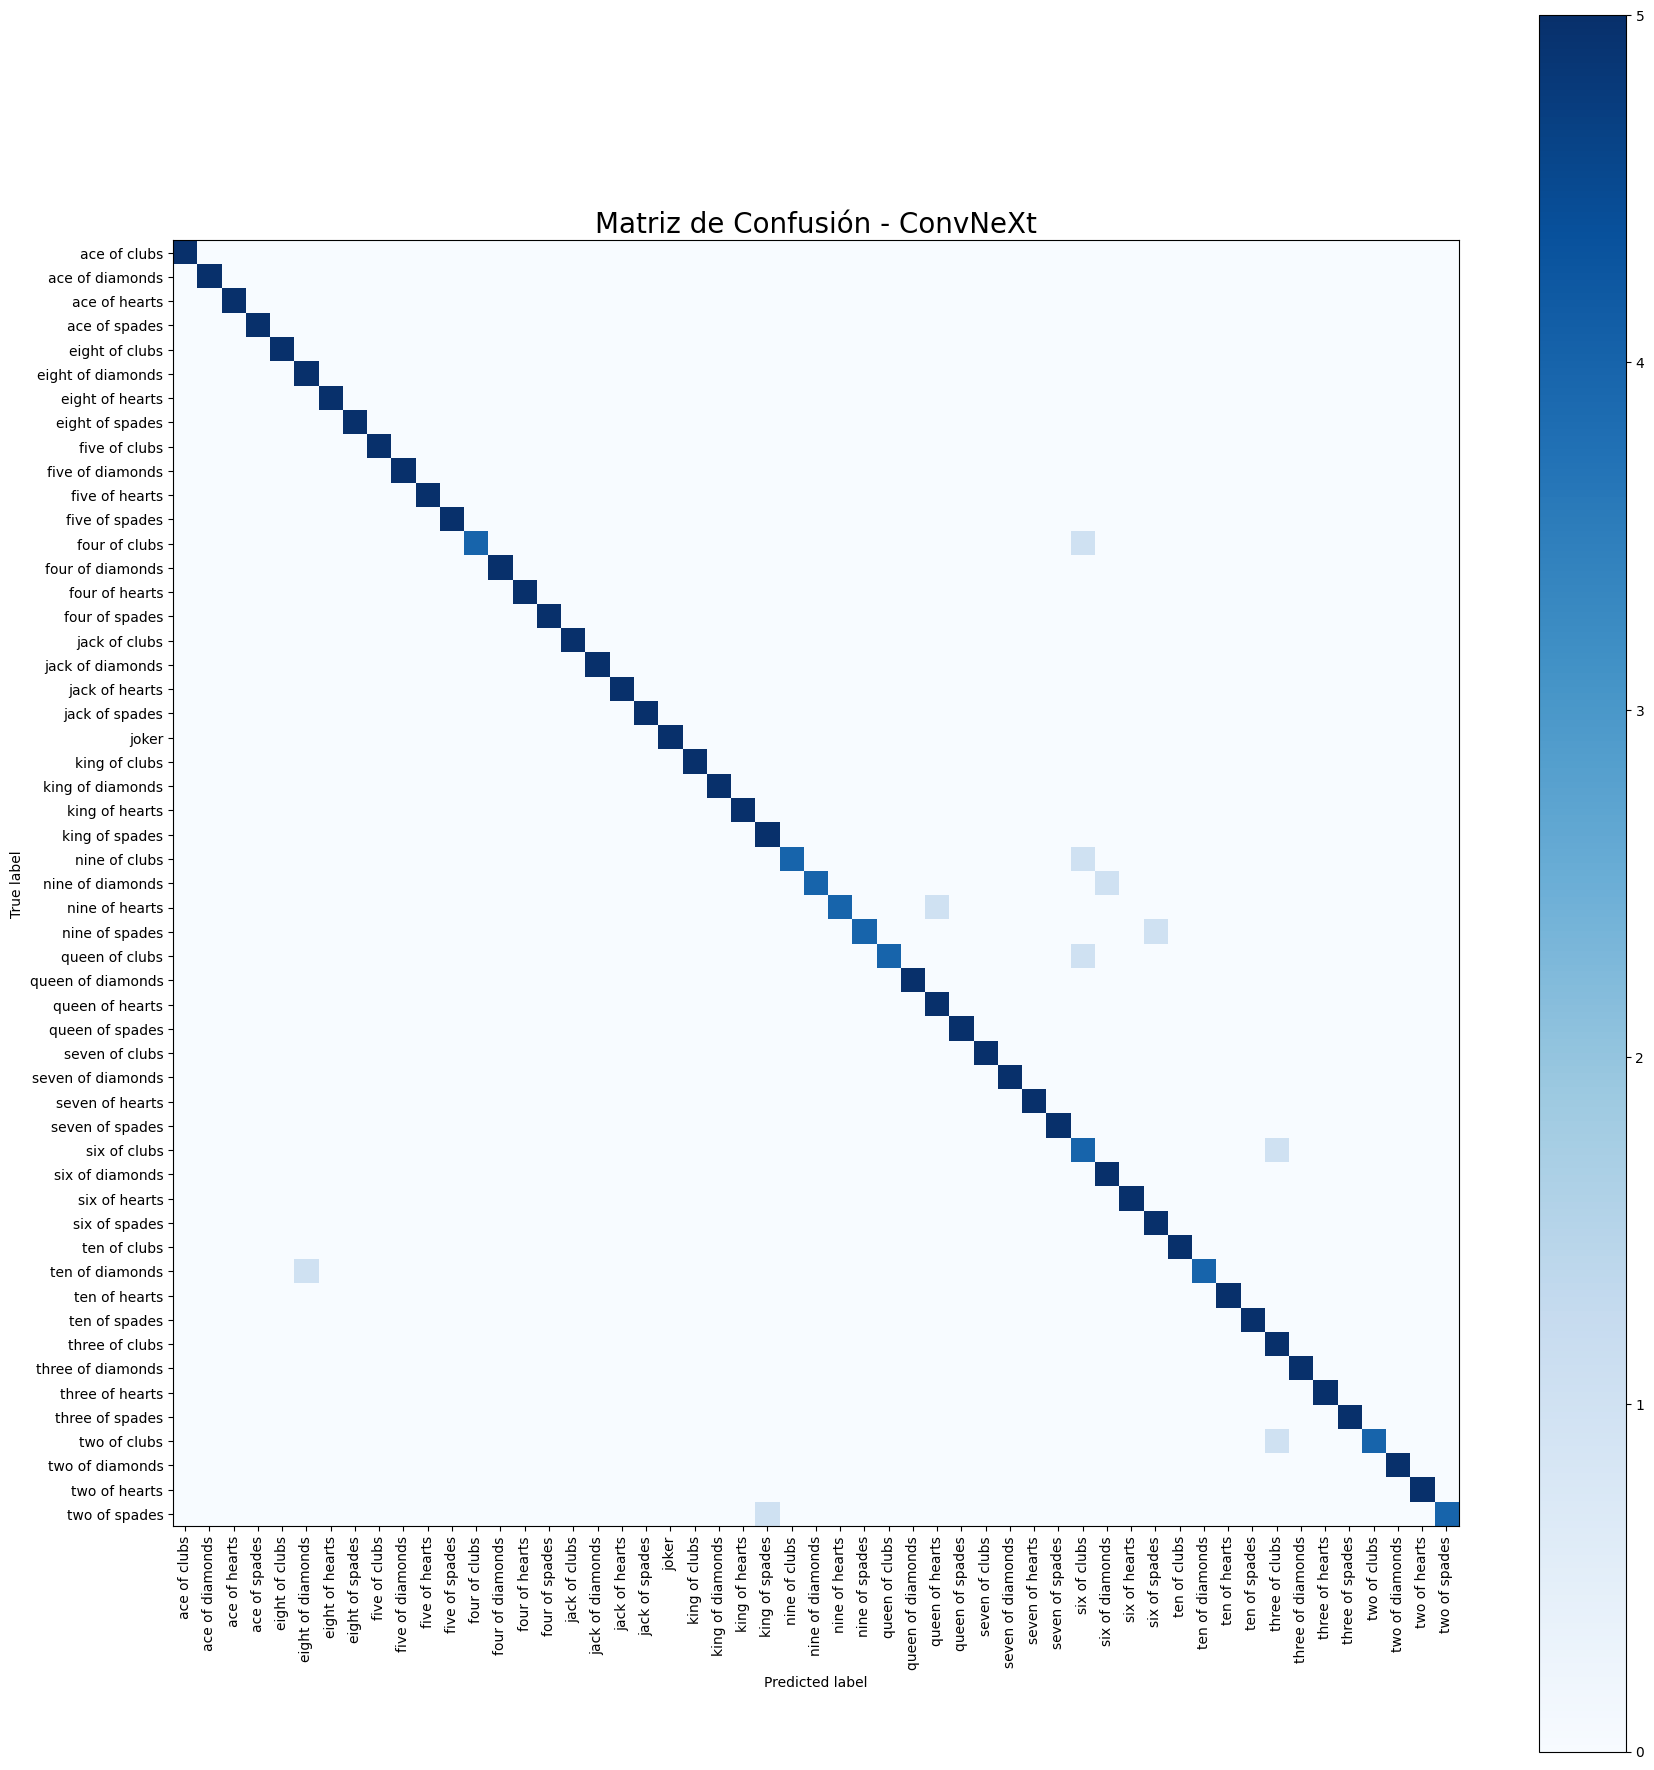

In [ ]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
# Import necessary components from the previous cell
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms as T
from torchvision.models import convnext_base, ConvNeXt_Base_Weights
from PIL import Image
import os

# Re-define Config class if not globally accessible or import it
# Assuming Config and PokerDataset, PokerConvNeXt classes and get_transforms, apply_tta functions are in memory from previous cell execution

def compute_confusion_matrix(model, test_loader, class_names, use_tta=False):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(Config.device)
            labels = labels.to(Config.device)

            # Si usas TTA
            if use_tta and Config.use_tta:
                outputs = apply_tta(model, inputs, Config.tta_transforms)
            else:
                outputs = torch.softmax(model(inputs), dim=1)

            preds = outputs.argmax(dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Convertir a numpy
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Generar matriz
    cm = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(18, 18))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(include_values=False, cmap="Blues", ax=plt.gca(), xticks_rotation=90)
    plt.title("Matriz de Confusión - ConvNeXt", fontsize=20)
    plt.tight_layout()
    plt.show()

    return cm

# ======================================================
# EJECUCIÓN REAL (asegurar que model y test_dataset estén disponibles)
# ======================================================

# Re-initialize dataset and loader
# Need DATA_PATH which is assumed to be globally available from previous cell
# Need Config class, PokerDataset class, and get_transforms function from previous cell

# Ensure Config.num_classes is set if not already
# Assuming Config.train_dir, Config.test_dir, Config.device, Config.img_size, Config.batch_size, Config.drop_path_rate are available

train_transform, eval_transform = get_transforms()
test_dataset = PokerDataset(Config.test_dir, transform=eval_transform)
test_loader = DataLoader(test_dataset, batch_size=Config.batch_size,
                        shuffle=False, num_workers=2, pin_memory=True)

# Re-instantiate the model and load the best weights
model = PokerConvNeXt(
    num_classes=len(test_dataset.classes), # Use the actual number of classes from the dataset
    drop_path_rate=Config.drop_path_rate
).to(Config.device)

# Path to the saved model checkpoint
checkpoint_path = 'best_convnext.pth'
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=Config.device)
    model.load_state_dict(checkpoint['model_state_dict'])


# Obtener nombres de clases desde test_dataset
class_names = test_dataset.classes

cm = compute_confusion_matrix(model, test_loader, class_names, use_tta=True)


A partir del análisis de la matriz de confusión, se observa que una parte significativa de los errores se produce en la predicción del valor 9, independientemente del palo al que pertenezca. Esto permite intuir que el modelo presenta mayores dificultades cuando debe identificar un número elevado de patrones visuales, ya que el 9 es la carta que contiene un mayor número de elementos gráficos, ya sean corazones, picas, diamantes o tréboles.

Ante este comportamiento, se podría plantear como línea de mejora la modificación de ciertos hiperparámetros con el objetivo de forzar al modelo a prestar mayor atención a los detalles visuales. Ajustes relacionados con la profundidad del fine-tuning, la resolución de entrada o la regularización podrían contribuir a mejorar la discriminación en este tipo de casos más complejos.